In [1]:
from dataclasses import dataclass
from math import atan2, cos, sin, sqrt
import numpy as np
from typing import List
from random import uniform
import math
from matplotlib import pyplot as plt
from numpy import linspace
from itertools import combinations as comb

@dataclass
class Point():
    x: float
    y: float
    
    def __iter__(self):
        yield self.x
        yield self.y
        
    def __len__(self):
        return 99
        
    def __getitem__(self, n):
        if n > 1:
            raise ValueError("Invalid index")
        
        return [self.x, self.y][n]
    
    def __add__(self, other):
        return Point(self.x + other.x, self.y + other.y)
    

def calculate_distance(point1: Point, point2: Point):
    delta_x = point2.x - point1.x
    delta_y = point2.y - point1.y
    return sqrt(delta_x ** 2 + delta_y ** 2)
    

def calculate_angle_between_points(point1: Point, point2: Point):
    """
    angle from point 1 to point 2
    """
    delta_x = point2.x - point1.x
    delta_y = point2.y - point1.y
    theta_radians = atan2(delta_y, delta_x)
    return theta_radians


def calculate_end_point(point: Point, angle_radians: float, distance: float):
    """
    get end point, given a start, angle, and distance
    """
    x = cos(angle_radians) * distance
    y = sin(angle_radians) * distance  
    return point + Point(x, y)


def calculate_average_point(points: List[Point]):
    x = sum(point.x for point in points) / len(points)
    y = sum(point.y for point in points) / len(points)
    return Point(x, y)


def calculate_average_error(target: Point, points: List[Point]):
    return sum(calculate_distance(target, point) for point in points) / len(points)



In [2]:
point = Point(5, 8)
point2 = Point(3, 34)

In [5]:
for foo in point:
    print(foo)

5
8


In [6]:
len(point)

99

In [9]:
point[1]

8

In [10]:
point3 = point + point2

In [11]:
point3 + point2

Point(x=11, y=76)

# Triangulate with error

In [12]:
def calculate_distance_variables(points: List[Point], distances: List[float]):
    X, Y = list(zip(*points))
    
    A = -2*X[0] + 2*X[1]
    B = -2*Y[0] + 2*Y[1]
    C = distances[0]**2 - distances[1]**2 - X[0]**2 + X[1]**2 - Y[0]**2 + Y[1]**2
    D = -2*X[1] + 2*X[2]
    E = -2*Y[1] + 2*Y[2]
    F = distances[1]**2 - distances[2]**2 - X[1]**2 + X[2]**2 - Y[1]**2 + Y[2]**2
    
    return A, B, C, D, E, F


def triangulate(rpi_locations: List[Point], distances: List[float]):
    A, B, C, D, E, F = calculate_distance_variables(rpi_locations, distances)

    A_mat = np.array([[A, B], [D, E]])
    B_mat = np.array([[C], [F]])

    A_inv = np.linalg.inv(A_mat)
    
    guess = Point(*np.matmul(A_inv, B_mat).flat)
    
    return guess
    
    
def calculate_error(rpi_locations: List[Point], distances: List[float], triangulated: Point):

    angles = [calculate_angle_between_points(pi, triangulated) for pi in rpi_locations]
    end_points = [calculate_end_point(pi, angle, distance) for pi, angle, distance in zip(rpi_locations, angles, distances)]
    errors = [calculate_distance(end_point, triangulated) for end_point in end_points]

    error = sum(errors) / 3
    return error

def calculate_rssi_distance(rssi: float, n: float = 1.5, c: float = 10, A0: float = 2):
    x = float((rssi-A0)/(-10*n)) #Log Normal Shadowing Model considering d0 =1m where
    distance = (math.pow(10,x) * 100) + c
    return distance

In [13]:
def calculate_constants(rpi_locations: List[Point], rssi_list: List[float], n: float = 0, c: float = 0, a0: float = 0):
    n = 0    #Path loss exponent(n) = 1.5
    c = 1   #Environment constant(C) = 10
    A0 = 1   #Average RSSI value at d0

    results = []
    
    x = linspace(1, 100, 1000)

    for n in x:
        distances = [calculate_rssi_distance(rssi, n, c, A0) for rssi in rssi_list]
        guess = triangulate(rpi_locations, distances)
        error = calculate_error(rpi_locations, distances, guess)
        results.append(error)
    
    n = x[results.index(min(results))]
    results.clear()
    
    x = linspace(0, 50, 1000)
    
    for c in x:
        distances = [calculate_rssi_distance(rssi, n, c, A0) for rssi in rssi_list]
        guess = triangulate(rpi_locations, distances)
        error = calculate_error(rpi_locations, distances, guess)
        results.append(error)
        
    c = x[results.index(min(results))]
    results.clear()
    
    for A0 in x:
        distances = [calculate_rssi_distance(rssi, n, c, A0) for rssi in rssi_list]
        guess = triangulate(rpi_locations, distances)
        error = calculate_error(rpi_locations, distances, guess)
        results.append(error)
        
    A0 = x[results.index(min(results))]
    
    return n, c, A0




In [15]:
# print(distances, guess)

In [20]:
results = []

for n in range(1, 200):
    distances = [calculate_rssi_distance(rssi, n, c, A0) for rssi in rssi_list]
    guess = triangulate(rpi_locations, distances)
    error = calculate_error(rpi_locations, distances, guess)
    results.append(error)

fig, ax = plt.subplots(figsize=(15, 10))
plt.plot(x, results, "-o")
ax.grid()

NameError: name 'rssi_list' is not defined

In [17]:
# print(results[25:31])
x[results.index(min(results))]

NameError: name 'x' is not defined

In [68]:

rpi_locations = [Point(0.75, 25), Point(1.33, 3.5), Point(40, 2), Point(42, 24)][:3]

n = 30    #Path loss exponent(n) = 1.5
A0 = 0   #Average RSSI value at d0

rssi_list = [207.4322222222222, 195.91685144124168, 191.1609322974473]

results = []

x = linspace(0, 5, 100)

for c in x:
    distances = [calculate_rssi_distance(rssi, n, c, A0) for rssi in rssi_list]
    guess = triangulate(rpi_locations, distances)
    error = calculate_error(rpi_locations, distances, guess)
    results.append(error)

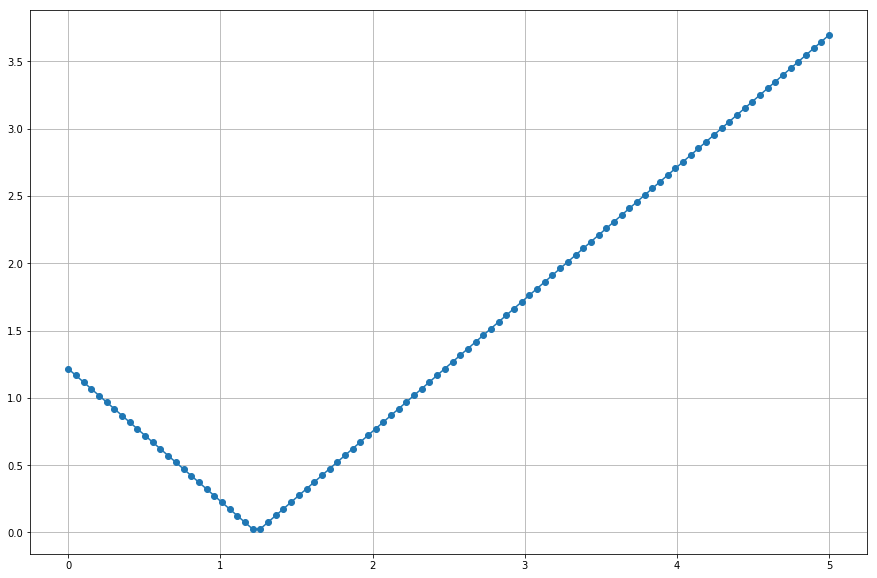

In [69]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.plot(x, results, "-o")
ax.grid()

In [70]:
x[results.index(min(results))]

1.2121212121212122

In [61]:
rpi_locations = [Point(0.75, 25), Point(1.33, 3.5), Point(40, 2), Point(42, 24)][:3]

n = 30    #Path loss exponent(n) = 1.5
c = 1.2121212121212122

rssi_list = [207.4322222222222, 195.91685144124168, 191.1609322974473]

results = []

x = linspace(0, 350, 200)

for A0 in x:
    distances = [calculate_rssi_distance(rssi, n, c, A0) for rssi in rssi_list]
    guess = triangulate(rpi_locations, distances)
    error = calculate_error(rpi_locations, distances, guess)
    results.append(error)

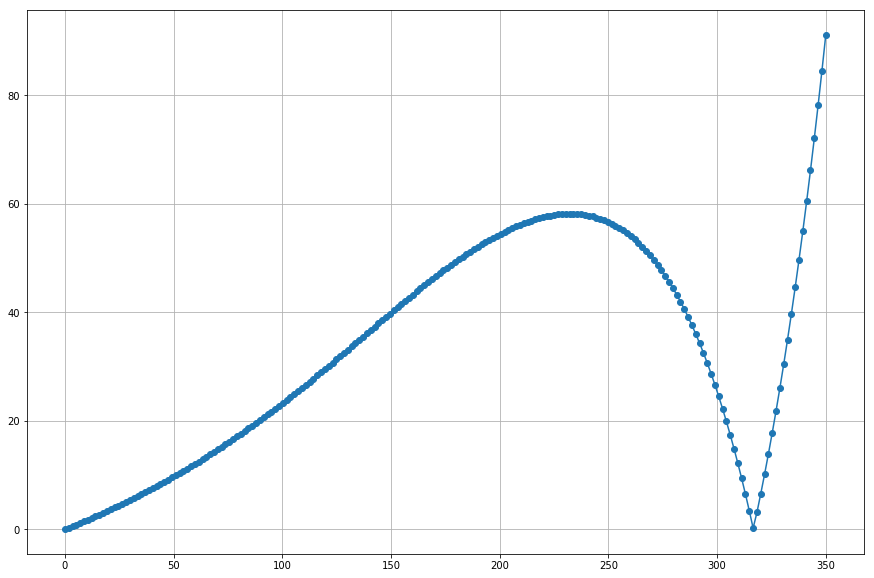

In [62]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.plot(x, results, "-o")
ax.grid()

In [63]:
x[results.index(min(results))]
# 0.14141414141414144

0.0

In [21]:
# n = 30.05940594059406
# c = 1.005100510051005
# A0 = 1.0001000100010002

rpi_locations = [Point(0, 0), Point(0, 26.26), Point(40.66, 0), Point(40.66, 26.26)]
# rssi_list = [207.4322222222222, 195.91685144124168, 191.1609322974473, 191.260821]
# rssi_list = [192.6889612445168, 191.8190493419565, 189.18289539143413, 185.45716482721187]
rssi_list = [189.0, 213.0, 177.0, 184.5]

n, c, A0 = calculate_constants(rpi_locations[:3], rssi_list[:3])

# for i in range(1, 10):
#     n, c, A0 = calculate_constants(rpi_locations[:3], rssi_list[:3], n, c, A0)

distances = [calculate_rssi_distance(rssi, n, c, A0) for rssi in rssi_list]

guess_results = []

for combination in comb(zip(rpi_locations, distances), 3):
    rpis, dists = zip(*combination)
    guess = triangulate(rpis, dists)
    guess_results.append(guess)
    print(guess)
    
# guess = triangulate(rpi_locations, distances)
# error = calculate_error(rpi_locations, distances, guess)

angles = [calculate_angle_between_points(pi, guess) for pi in rpi_locations]
end_points = [calculate_end_point(pi, angle, distance) for pi, angle, distance in zip(rpi_locations, angles, distances)]

Point(x=18.848207838958594, y=16.658960106310744)
Point(x=17.525823354880465, y=16.658960106310744)
Point(x=18.848207838958594, y=14.611429522814298)
Point(x=17.525823354880465, y=14.611429522814298)


In [22]:
calculate_average_point(guess_results)

Point(x=18.18701559691953, y=15.63519481456252)

In [23]:
guess_results

[Point(x=18.848207838958594, y=16.658960106310744),
 Point(x=17.525823354880465, y=16.658960106310744),
 Point(x=18.848207838958594, y=14.611429522814298),
 Point(x=17.525823354880465, y=14.611429522814298)]

In [24]:
list(zip(*i))

NameError: name 'i' is not defined

In [25]:
list(comb(rpi_locations, 3))

[(Point(x=0, y=0), Point(x=0, y=26.26), Point(x=40.66, y=0)),
 (Point(x=0, y=0), Point(x=0, y=26.26), Point(x=40.66, y=26.26)),
 (Point(x=0, y=0), Point(x=40.66, y=0), Point(x=40.66, y=26.26)),
 (Point(x=0, y=26.26), Point(x=40.66, y=0), Point(x=40.66, y=26.26))]

In [26]:
list(comb(zip(rpi_locations, rssi_list), 3))

[((Point(x=0, y=0), 189.0),
  (Point(x=0, y=26.26), 213.0),
  (Point(x=40.66, y=0), 177.0)),
 ((Point(x=0, y=0), 189.0),
  (Point(x=0, y=26.26), 213.0),
  (Point(x=40.66, y=26.26), 184.5)),
 ((Point(x=0, y=0), 189.0),
  (Point(x=40.66, y=0), 177.0),
  (Point(x=40.66, y=26.26), 184.5)),
 ((Point(x=0, y=26.26), 213.0),
  (Point(x=40.66, y=0), 177.0),
  (Point(x=40.66, y=26.26), 184.5))]

In [27]:
# error = calculate_error(rpi_locations, distances, guess)
# error

# Drawing

In [28]:
import matplotlib as mpl
from matplotlib import pyplot as plt

%matplotlib inline

In [29]:
rpi_locations

[Point(x=0, y=0),
 Point(x=0, y=26.26),
 Point(x=40.66, y=0),
 Point(x=40.66, y=26.26)]

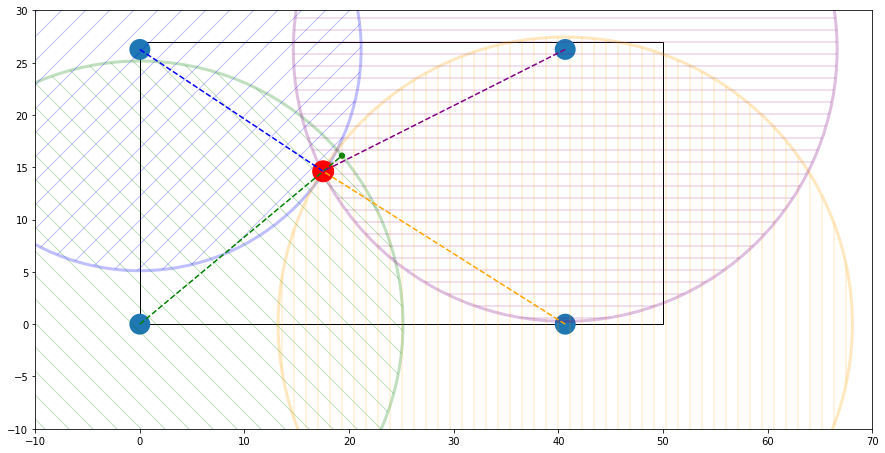

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

rect = mpl.patches.Rectangle((0,0), 50, 27, linewidth=1, fill=False)
ax.add_patch(rect)

ax.set_xlim(-10, 70)
ax.set_ylim(-10, 30)

colors = ['green', 'blue', 'orange', 'purple']
hatches = ['\\', '/', '|', '-']
for pi, dist, pi_guess, color, hatch in zip(rpi_locations, distances, end_points, colors, hatches):
    pi_circ = mpl.patches.Circle(pi, 1)
    ax.add_patch(pi_circ)
    
    dist_circ = mpl.patches.Circle(pi, dist, fill=False, color=color, hatch=hatch, linewidth=3, alpha=0.25)
    ax.add_patch(dist_circ)
    
    plt.plot([pi.x, pi_guess.x], [pi.y, pi_guess.y], '--', color=color)
    guess_circ = mpl.patches.Circle(pi_guess, 0.25, color=color)
    ax.add_patch(guess_circ)

guess_circ = mpl.patches.Circle(guess, 1, fill=True, color='red')
ax.add_patch(guess_circ)
    
ax.set_aspect('equal', 'box')

plt.show()

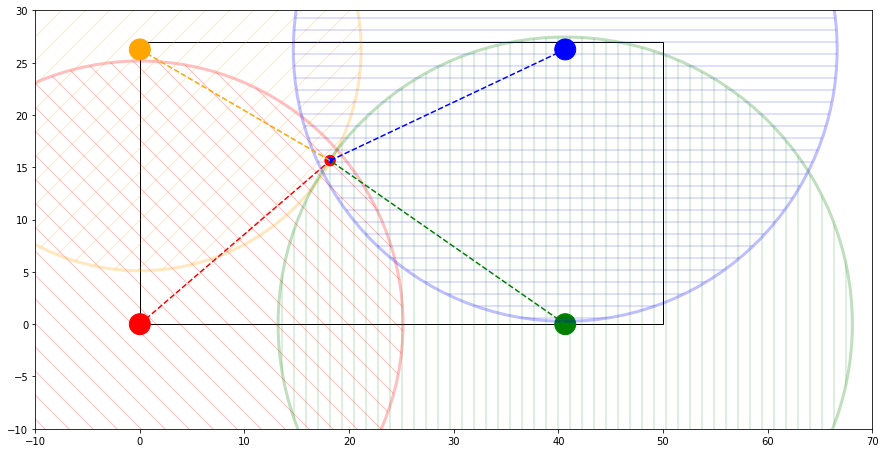

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

rect = mpl.patches.Rectangle((0,0), 50, 27, linewidth=1, fill=False)
ax.add_patch(rect)

ax.set_xlim(-10, 70)
ax.set_ylim(-10, 30)

distances = [calculate_rssi_distance(rssi, n, c, A0) for rssi in rssi_list]

angles = [calculate_angle_between_points(pi, guess) for pi in rpi_locations]
end_points = [calculate_end_point(pi, angle, distance) for pi, angle, distance in zip(rpi_locations, angles, distances)]

colors = ['red', 'orange', 'green', 'blue']
hatches = ['\\', '/', '|', '-']
for pi, distance, color, hatch in zip(rpi_locations, distances, colors, hatches):
    pi_circ = mpl.patches.Circle(pi, 1, color=color)
    ax.add_patch(pi_circ)
    
    pi_circ = mpl.patches.Circle(pi, distance, fill=False, color=color, hatch=hatch, linewidth=3, alpha=0.25)
    ax.add_patch(pi_circ)

for guess, color in zip(guess_results, colors):
    guess_circle = mpl.patches.Circle(guess, 0.3, color="navy")
    ax.add_patch(guess_circle)

guess_point = calculate_average_point(guess_results)
guess_circle = mpl.patches.Circle(guess_point, 0.5, color="red")
ax.add_patch(guess_circle)

for pi, color in zip(rpi_locations, colors):
    plt.plot([pi.x, guess_point.x], [pi.y, guess_point.y], '--', color=color)
    guess_circ = mpl.patches.Circle(guess_point, 0.25, color=color)
    ax.add_patch(guess_circ)

# guess_circ = mpl.patches.Circle(guess, 1, fill=True, color='red')
# ax.add_patch(guess_circ)
    
ax.set_aspect('equal', 'box')

plt.show()

In [115]:
guess_point

Point(x=18.18701559691953, y=15.63519481456252)

In [ ]:
list_a = [1, 2, 3, 4, 5]
list_b = "a b c d e".split()

for foo in zip(list_a, list_b):
    print(foo)

